In [41]:
import pandas as pd
import os
from pathlib import Path
from PIL import Image
import random
import torch
from typing import Literal
import torchvision
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm
import wandb
import torchmetrics
import shutil
import pytorch_lightning as pl
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
RAW_DATA_DIR = Path('raw/Garbage classification/')
DATA_DIR = Path('data')

<BarContainer object of 6 artists>

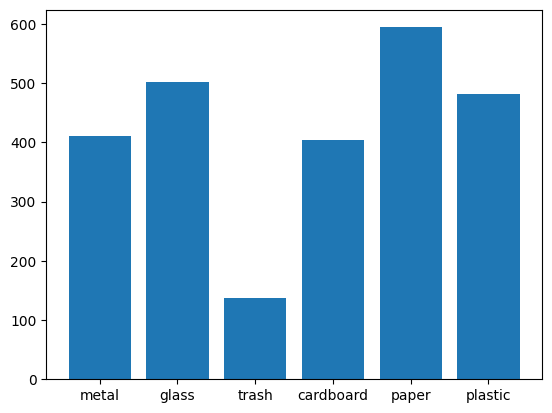

In [46]:
dct = {}
for cls in os.listdir(RAW_DATA_DIR):
    images = Path(RAW_DATA_DIR / cls).glob('*')
    # print(cls, ' has ', len(list(images)))
    dct[cls] = len(list(images))

plt.bar(dct.keys(), dct.values())

In [ ]:
classes = os.listdir(RAW_DATA_DIR)
train_size = 0.80

os.makedirs(DATA_DIR, exist_ok=True)

def copy_images(image_list, src_dir, dest_dir, cls, train=True):
    os.makedirs(dest_dir, exist_ok=True)
    os.makedirs(dest_dir / ('train' if train else 'test'), exist_ok=True)
    os.makedirs(dest_dir / ('train' if train else 'test') / cls, exist_ok=True)
    for img_name in image_list:
        if train:
            shutil.copy(src_dir / cls / img_name, dest_dir / 'train' / cls / img_name)
        else:
            shutil.copy(src_dir / cls / img_name, dest_dir / 'test' / cls / img_name)

# for cls in classes:
#     cls_path = RAW_DATA_DIR / cls
#     images = os.listdir(cls_path)
#     n_train = int(len(images) * train_size)
#     random.shuffle(images)
#     train_images = images[:n_train]
#     test_images = images[n_train:]
#     copy_images(train_images, RAW_DATA_DIR, DATA_DIR, cls, train=True)
#     copy_images(test_images, RAW_DATA_DIR, DATA_DIR, cls, train=False)

In [59]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor()
])

In [60]:
train_dataset = ImageFolder(DATA_DIR / 'train', transform=transformers)
test_dataset = ImageFolder(DATA_DIR / 'test', transform=transformers)
assert train_dataset.class_to_idx == test_dataset.class_to_idx

idx_to_class = {i:c for c, i in train_dataset.class_to_idx.items()}
idx_to_class

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [61]:
class DataLoaderWrapper(pl.LightningDataModule):
    def __init__(self, 
                 train_dataset:torch.utils.data.Dataset,
                 test_dataset:torch.utils.data.Dataset,
                 batch_size:int=32,
                 num_workers:int=4):
        super().__init__()
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
 
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )
 
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

In [80]:
class SimpleCNN(nn.Module):
    def __init__(self, 
                 num_layers=5, # m
                 filter_size=3, # k
                 num_dense=128, # n
                 conv_activation=nn.ReLU,
                 dense_activation=nn.ReLU,
                 in_channels=3,
                 num_classes=6,
                 stride=1,
                 input_size=128,
                 base_features=16,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        layers = []
        out_channels = in_channels
        w, h = input_size, input_size
        for i in range(num_layers):
            out_channels = base_features * (2 ** i)
            layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=filter_size,
                    padding='same',
                    stride=stride
                )
            )
            layers.append(conv_activation())
            layers.append(nn.MaxPool2d(kernel_size=2))
            
            w, h = w//2, h//2
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)
        nn.Flatten()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_channels*w*h, num_dense),
            dense_activation(),
            nn.Linear(num_dense, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        
        return x



In [ ]:
# num_filters -> m 
# kernel -> k 
# dense -> n
# base_features = 16
# c_in -> 3 (input channels)

# --- CONV ---
# param in a layer -> (c_in * k * k + 1) * c_out
# c_out = c_in * (2 ** i)
# param per layer -> (3 * k * k + 1) * (base_features * (2 ** i)) # for i == 0
# param per layer -> ((base_features * (2 ** (i-1))) * k * k + 1) * (base_features * (2 ** i)) # for i > 0

# --- DENSE ---
# out_channels -> base_features * (2 ** (m-1)) # c_out of last conv layer
# w_out_convs -> w_in // (2**m)
# h_out_convs = w_out_convs
# param in dense layer[1] -> (base_features * (2 ** (m-1)) * h_out_convs * w_out_convs + 1) * n # +1 for bias
# dense layer[3] -> n * 6 + 6 # classes => 6
# dense total = (base_features * (2 ** (m-1)) + 1) * n + n * 6 + 6

# --- TOTAL ---
# total params -> (3 * k * k + 1) * (base_features * (2 ** i)) + summation(((base_features * (2 ** (i-1))) * k * k + 1) * (base_features * (2 ** i)) for i=1 to m-1) + (base_features * (2 ** (m-1)) + 1) * n + n * 6 + 6

def calculate_param(
        m:int, k:int, n:int, base_features:int, c_in:int, w_in:int, h_in:int
):
    """
    - num_filters -> m (5) 
    - kernel -> k (3)
    - dense -> n (128)
    - base_features = 16
    - c_in -> 3 (input channels)
    """
    param_conv0 = (c_in*k*k + 1) * base_features 
    print(f"param at conv0: {param_conv0}")
    param_conv_m = 0
    for i in range(1, m):
        param_conv_m += ((base_features * (2 ** (i-1))) * k * k + 1) * (base_features * (2 ** i))
        print(f"param at conv{i}: {((base_features * (2 ** (i-1))) * k * k + 1) * (base_features * (2 ** i))}")

    print(f"after m convs: {param_conv_m}")
    conv_total = param_conv0 + param_conv_m

    w_out_convs = w_in // (2**m)
    h_out_convs = h_in // (2**m)
    dense_l1 = (base_features*(2**(m-1))* w_out_convs * h_out_convs + 1) * n
    print(f"param after dense1: {dense_l1}")
    dense_l3 = 6 * n + 6
    print(f"param after dense3: {dense_l3}")
    total_params = conv_total + dense_l1 + dense_l3
    return total_params

calculate_param(m=5, k=3, n=128, base_features=16, c_in=3, w_in=128, h_in=128)

param at conv0: 448
param at conv1: 4640
param at conv2: 18496
param at conv3: 73856
param at conv4: 295168
after m convs: 392160
param after dense1: 524416
param after dense3: 774


917798

In [90]:
import torchinfo
m = SimpleCNN()
torchinfo.summary(m, input_size=(32, 3, 128, 128)).total_params

917798

In [67]:
from typing import Any


class ModelLightning(pl.LightningModule):
    def __init__(self, 
                 model,
                 idx_to_class:dict,
                 run:wandb.Run,
                 lr:float=1e-3,
                 class_weights:torch.Tensor = None,
                 *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        self.model = model

        self.run = run
        self.idx_to_class = idx_to_class

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss() if not class_weights else nn.CrossEntropyLoss(weight=class_weights)

        self.f1 = torchmetrics.F1Score('multiclass', num_classes=6,
                                       average=None)
        self.recall = torchmetrics.Recall('multiclass', num_classes=6, average=None)
        self.precision = torchmetrics.Precision('multiclass', num_classes=6, average=None)

        self.train_preds = []
        self.train_targets = []
        self.train_loss = []
        self.val_preds = []
        self.val_targets = []
        self.val_loss = []

    def forward(self, x) -> Any:
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x)
        loss = self.criterion(yhat, y)

        self.train_preds.append(yhat.detach())
        self.train_targets.append(y)
        self.train_loss.append(loss.item())
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x)
        self.val_preds.append(yhat.detach())
        self.val_targets.append(y)
        loss = self.criterion(yhat, y)
        self.val_loss.append(loss.item())
    
    def on_train_epoch_end(self) -> None:
        self._shared_logging(mode='train',
                             preds=self.train_preds,
                             targets=self.train_targets,
                             losses=self.train_loss)
    
    def on_validation_epoch_end(self) -> None:
        self._shared_logging(mode='val',
                             preds=self.val_preds,
                             targets=self.val_targets,
                             losses=self.val_loss)

    def _shared_logging(self, mode:Literal['train', 'val'], 
                        preds, targets, losses):
        _preds = torch.cat(preds).argmax(1)
        loss = torch.mean(torch.tensor(losses))
        f1 = self.f1(_preds, torch.cat(targets))
        recall = self.recall(_preds, torch.cat(targets))
        precision = self.precision(_preds, torch.cat(targets)) 

        # per class
        for i in range(6):
            self.run.log(data={
                f'{mode}_f1_class_{self.idx_to_class[i]}': f1[i],
                f'{mode}_recall_class_{self.idx_to_class[i]}': recall[i],
                f'{mode}_precision_class_{self.idx_to_class[i]}': precision[i],
            })
        
        self.run.log({
            f'{mode}_loss': loss,
        })
        self.log(
            f'{mode}_loss', loss,
            prog_bar=True, on_epoch=True
        )

        preds.clear()
        targets.clear()
        losses.clear()
        self.f1.reset()
        self.recall.reset()
        self.precision.reset()

    def configure_optimizers(self):
        return self.optimizer

In [57]:
class CFG:
    batch_size = 64
    num_workers = 4
    max_epochs = 10
    lr = 1e-3
    num_layers=5 # m
    filter_size=3 # k
    num_dense=128 # n
    conv_activation=nn.ReLU
    dense_activation=nn.ReLU
    in_channels=3
    num_classes=6
    stride=1
    input_size=128
    num_classes = 6


run = wandb.init(
    project='garbage-classification',
    name='simple-cnn',
    config=CFG().__dict__
)

In [68]:
model = SimpleCNN(
    num_layers=CFG.num_layers,
    filter_size=CFG.filter_size,
    num_dense=CFG.num_dense,
    conv_activation=CFG.conv_activation,
    dense_activation=CFG.dense_activation,
    in_channels=CFG.in_channels,
    num_classes=CFG.num_classes,
    stride=CFG.stride,
    input_size=CFG.input_size
)

pl_model = ModelLightning(
    model=model,
    idx_to_class=idx_to_class,
    run=run,
    lr=CFG.lr
)

dm = DataLoaderWrapper(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    batch_size=CFG.batch_size,
    num_workers=CFG.num_workers
)

trainer = pl.Trainer(
    max_epochs=CFG.max_epochs,
    accelerator='auto',
    devices='auto'
)

trainer.fit(pl_model, datamodule=dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | SimpleCNN           | 917 K  | train
1 | criterion | CrossEntropyLoss    | 0      | train
2 | f1        | MulticlassF1Score   | 0      | train
3 | recall    | MulticlassRecall    | 0      | train
4 | precision | MulticlassPrecision | 0      | train
----------------------------------------------------------
917 K     Trainable params
0         Non-trainable params
917 K     Total params
3.671     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/nevrohelios/miniconda3/envs/flsplit/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
